In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
# Import Graphing Library: Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

### Scrape Table from Wikipedia - Toronto Neighbourhood & Location Details

In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')

In [4]:
table_post_code = soup.find('table')
fields = table_post_code.find_all('td')

postcode = []
borough = []
neighbourhood = []

for i in range(0, len(fields), 3):
    postcode.append(fields[i].text.strip())
    borough.append(fields[i+1].text.strip())
    neighbourhood.append(fields[i+2].text.strip())
        
df_post_code = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()
df_post_code.columns = ['Postcode', 'Borough', 'Neighbourhood']
df_post_code.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Sample Data table lines:

In [5]:
# Clean Table: Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df_post_code['Borough'].replace('Not assigned',np.nan,inplace=True)
df_post_code.dropna(subset=['Borough'],inplace=True)
df_post_code.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
# More than one neighborhood can exist in one postal code area. 
# For example, in the table on the Wikipedia page, you will notice that M5A 
# is listed twice and has two neighborhoods: Harbourfront and Regent Park. 
# These two rows will be combined into one row with the neighborhoods 
# separated with a comma as shown in row 11 in the above table.
df_post_code = df_post_code.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df_post_code.columns = ['Postcode', 'Borough', 'Neighbourhood']

In [7]:
# Replace 'Not assigned' Neighbourhood with Borough
df_post_code['Neighbourhood']= np.where(df_post_code['Neighbourhood']=='Not assigned',df_post_code['Borough'],df_post_code['Neighbourhood'])

In [8]:
df_post_code.shape

(103, 3)

#### Import Latitude and Longitude Information

In [9]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.columns = ['Postcode', 'Latitude', 'Longitude']
df_pos_new = pd.merge(df_post_code,df_geo, on=['Postcode'], how='inner')
df_tor = df_pos_new[['Borough', 'Neighbourhood', 'Postcode', 'Latitude', 'Longitude']].copy()

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_tor['Borough'].unique()),
        df_tor.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [11]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 25.7933414, -100.2740662.


In [12]:
# Rename Neighbourhood to Neighborhood for consistency
df_tor.rename(columns={"Neighbourhood": "Neighborhood"},inplace=True)

In [13]:
df_tor

,Borough,Neighborhood,Postcode,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",M1B,43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",M1C,43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,Scarborough,Woburn,M1G,43.770992,-79.216917
4,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",M1K,43.727929,-79.262029
7,Scarborough,"Golden Mile, Clairlea, Oakridge",M1L,43.711112,-79.284577
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",M1M,43.716316,-79.239476
9,Scarborough,"Birch Cliff, Cliffside West",M1N,43.692657,-79.264848


#### Create a map of Toronto City

In [14]:
# create map of New York using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

### General Explore Toronto Area - Neighbourhood Density by Borough

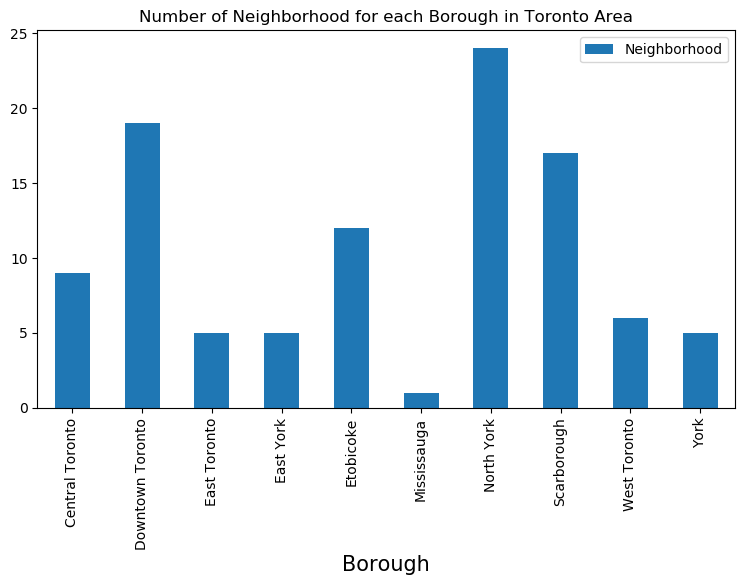

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto Area')
plt.xlabel('Borough', fontsize = 15)
df_tor.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

### Ethnic Groups (Top 3)

In [16]:
!conda install -c conda-forge wikipedia --yes 
import wikipedia as wp

Solving environment: done

# All requested packages already installed.



In [17]:
html_ethics = wp.page("Demographics of Toronto").html().encode("UTF-8")

#### Toronto & East York

In [18]:
trt_estyork_ethics = pd.read_html(html_ethics, header = 0)[12]
trt_estyork_ethics = trt_estyork_ethics.iloc[:,0:8]
trt_estyork_ethics = trt_estyork_ethics.rename(columns={'%':'#1 Ethinc in %',
                                                      '%.1':'#2 Ethinc in %',
                                                      '%.2':'#3 Ethinc in %'})

In [19]:
trt_estyork_ethics['Ethnic Origin #1 Population'] = trt_estyork_ethics['Population']*trt_estyork_ethics['#1 Ethinc in %']/100
trt_estyork_ethics['Ethnic Origin #2 Population'] = trt_estyork_ethics['Population']*trt_estyork_ethics['#2 Ethinc in %']/100
trt_estyork_ethics['Ethnic Origin #3 Population'] = trt_estyork_ethics['Population']*trt_estyork_ethics['#3 Ethinc in %']/100
trt_estyork_ethics['Region']='Toronto & East York'

In [20]:
trt_estyork_ethics

,Riding,Population,Ethnic Origin #1,#1 Ethinc in %,Ethnic Origin #2,#2 Ethinc in %,Ethnic Origin #3,#3 Ethinc in %,Ethnic Origin #1 Population,Ethnic Origin #2 Population,Ethnic Origin #3 Population,Region
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,18747.660,18290.400,16689.990,Toronto & East York
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,26241.270,21578.565,21361.695,Toronto & East York
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,24378.665,14605.720,13746.560,Toronto & East York
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,23737.235,21289.000,19905.215,Toronto & East York
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,24135.455,20552.025,19708.865,Toronto & East York
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,19413.900,16895.340,15950.880,Toronto & East York
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,20707.120,16686.320,16384.760,Toronto & East York
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,15635.630,13643.830,13345.060,Toronto & East York


#### North York

In [21]:
north_york_ethics = pd.read_html(html_ethics, header = 0)[13]
north_york_ethics = north_york_ethics.iloc[:,0:8]
north_york_ethics = north_york_ethics.rename(columns={'%':'#1 Ethinc in %',
                                                      '%.1':'#2 Ethinc in %',
                                                      '%.2':'#3 Ethinc in %'})

In [22]:
north_york_ethics['Ethnic Origin #1 Population'] = north_york_ethics['Population']*north_york_ethics['#1 Ethinc in %']/100
north_york_ethics['Ethnic Origin #2 Population'] = north_york_ethics['Population']*north_york_ethics['#2 Ethinc in %']/100
north_york_ethics['Ethnic Origin #3 Population'] = north_york_ethics['Population']*north_york_ethics['#3 Ethinc in %']/100
north_york_ethics['Region']='North York'
north_york_ethics

,Riding,Population,Ethnic Origin #1,#1 Ethinc in %,Ethnic Origin #2,#2 Ethinc in %,Ethnic Origin #3,#3 Ethinc in %,Ethnic Origin #1 Population,Ethnic Origin #2 Population,Ethnic Origin #3 Population,Region
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,30407.895,14206.005,12444.930,North York
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,16599.975,14228.550,13551.000,North York
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,35335.440,7961.380,7961.380,North York
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,13788.800,9910.700,9156.625,North York
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,17639.200,13903.840,9857.200,North York
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,19543.680,15370.290,15166.710,North York
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,9876.020,9689.680,9410.170,North York


#### Scarborough

In [23]:
scarb_ethics = pd.read_html(html_ethics, header = 0)[14]
scarb_ethics = scarb_ethics.iloc[:,0:8]
scarb_ethics = scarb_ethics.rename(columns={'%':'#1 Ethinc in %',
                                            '%.1':'#2 Ethinc in %',
                                            '%.2':'#3 Ethinc in %'})

In [24]:
scarb_ethics['Ethnic Origin #1 Population'] = scarb_ethics['Population']*scarb_ethics['#1 Ethinc in %']/100
scarb_ethics['Ethnic Origin #2 Population'] = scarb_ethics['Population']*scarb_ethics['#2 Ethinc in %']/100
scarb_ethics['Ethnic Origin #3 Population'] = scarb_ethics['Population']*scarb_ethics['#3 Ethinc in %']/100
scarb_ethics['Region']='Scarborough'
scarb_ethics

,Riding,Population,Ethnic Origin #1,#1 Ethinc in %,Ethnic Origin #2,#2 Ethinc in %,Ethnic Origin #3,#3 Ethinc in %,Ethnic Origin #1 Population,Ethnic Origin #2 Population,Ethnic Origin #3 Population,Region
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,14468.950,13474.900,12370.400,Scarborough
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,17543.790,15486.185,12453.925,Scarborough
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,48985.750,7712.650,NaN,Scarborough
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,16941.315,11970.510,11260.395,Scarborough
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,18200.700,11729.340,9808.155,Scarborough
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,45486.260,11517.980,9175.340,Scarborough


#### Etobicoke & York

In [25]:
Etob_York_ethics = pd.read_html(html_ethics, header = 0)[15]
Etob_York_ethics = Etob_York_ethics.iloc[:,0:8]
Etob_York_ethics = Etob_York_ethics.rename(columns={'%':'#1 Ethinc in %',
                                                    '%.1':'#2 Ethinc in %',
                                                    '%.2':'#3 Ethinc in %'})

In [26]:
Etob_York_ethics['Ethnic Origin #1 Population'] = Etob_York_ethics['Population']*Etob_York_ethics['#1 Ethinc in %']/100
Etob_York_ethics['Ethnic Origin #2 Population'] = Etob_York_ethics['Population']*Etob_York_ethics['#2 Ethinc in %']/100
Etob_York_ethics['Ethnic Origin #3 Population'] = Etob_York_ethics['Population']*Etob_York_ethics['#3 Ethinc in %']/100
Etob_York_ethics['Region']='Etobicoke & York'
Etob_York_ethics

,Riding,Population,Ethnic Origin #1,#1 Ethinc in %,Ethnic Origin #2,#2 Ethinc in %,Ethnic Origin #3,#3 Ethinc in %,Ethnic Origin #1 Population,Ethnic Origin #2 Population,Ethnic Origin #3 Population,Region
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,21805.920,20275.680,18362.880,Etobicoke & York
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,25965.120,9239.840,NaN,Etobicoke & York
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,17524.305,16595.865,14042.655,Etobicoke & York
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,16693.850,14736.640,10016.310,Etobicoke & York


In [27]:
trt_ethics_all = pd.concat([trt_estyork_ethics,north_york_ethics, scarb_ethics,Etob_York_ethics], ignore_index=True)

In [28]:
trt_ethics_top_chinese = (trt_ethics_all.loc[trt_ethics_all['Ethnic Origin #1']== 'Chinese']
                          .sort_values(by=['Population']))
trt_ethics_top_chinese = trt_ethics_top_chinese[['Riding','Population','Region']].reset_index().drop('index',axis=1)

In [29]:
trt_ethics_top_chinese 

,Riding,Population,Region
0,Scarborough North,97610,Scarborough
1,Scarborough-Agincourt,104225,Scarborough
2,Don Valley North,109060,North York
3,Willowdale,117405,North York


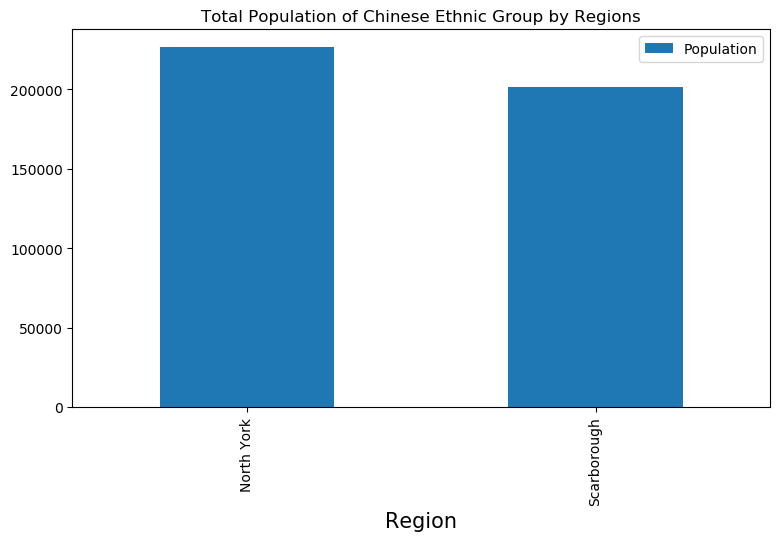

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Total Population of Chinese Ethnic Group by Regions')
plt.xlabel('Region', fontsize = 15)
trt_ethics_top_chinese.groupby('Region')['Population'].sum().plot(kind='bar')
plt.legend()
plt.show()

### School Information

In [31]:
import pandas as pd
import requests
 
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
 
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "1a714b5c-64c0-4cdf-9739-0086f80fb3ee"}
package = requests.get(url, params = params).json()
print(package["result"])
 
# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:
 
for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] }
        data = requests.get(url, params = p).json()
        df_school = pd.DataFrame(data["result"]["records"])
        break

{'license_title': 'Open Government Licence – Toronto', 'owner_unit': None, 'relationships_as_object': [], 'topics': 'Community services,Locations and mapping', 'owner_email': 'opendata@toronto.ca', 'excerpt': 'A geographical spatial file containing all of the address points of all of the schools within the City of Toronto.', 'private': False, 'owner_division': 'Toronto Police Services', 'num_tags': 9, 'id': '1a714b5c-64c0-4cdf-9739-0086f80fb3ee', 'metadata_created': '2019-07-23T17:58:32.641183', 'refresh_rate': 'Semi-annually', 'title': 'School Locations - All Types', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': None, 'license_id': 'open-government-licence-toronto', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'package_id': '1a714b5c-64c0-4cdf-9739-0086f80fb3ee', 'datastore_active': True, 'id': '02ef7447-54d9-4aa7-b76d-8ef8138ac546', 'size': None, 'format': 'GeoJSON', 'state': 'active', 'hash': '', 'description': ''

In [32]:
df_school.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry
0,23007,1,330677,A PLUS ACADEMY OF ADVANCEMENT,None,PR,None,2425 EGLINTON AVE E,Private,330677,2425,Eglinton Ave E,2425 Eglinton Ave E,M1K 5G8,Scarborough,Toronto,None,104008,111254,2425,None,None,None,125,323561.684,4843596.049,43.732091,-79.267107,"{""type"": ""Point"", ""coordinates"": [-79.26710393..."
1,23008,2,524780,A R S ARMENIAN PRIVATE SCHOOL,None,PR,None,50 HALLCROWN PL,Private,524780,50,Hallcrown Pl,50 Hallcrown Pl,M2J 1P7,North York,Toronto,None,104008,438652,50,None,None,None,5778,319037.215,4847803.338,43.770062,-79.323159,"{""type"": ""Point"", ""coordinates"": [-79.32315614..."
2,23009,3,20258267,A Y J GLOBAL ACADEMY,None,PR,None,4 LANSING SQ,Private,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,None,104008,438287,4,None,None,None,6007,318870.404,4848250.651,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641..."
3,23010,4,517961,A Y JACKSON SECONDARY SCHOOL,None,EP,Toronto District School Board,50 FRANCINE DR,English Public,517961,50,Francine Dr,50 Francine Dr,M2H 2G6,North York,Toronto,A. Y. Jackson Secondary School,102002,436260,50,None,None,None,5639,315536.964,4851708.323,43.805270,-79.366559,"{""type"": ""Point"", ""coordinates"": [-79.36655529..."
4,23011,5,13967401,ABACUS MONTESSORI LEARNING CENTRE,None,PR,None,4 CREDIT UNION DR,Private,13967401,4,Credit Union Dr,4 Credit Union Dr,M4A 2N8,North York,Toronto,Latvian Canadian Centre,106007,444179,4,None,None,None,5294,319381.840,4842846.853,43.725441,-79.319013,"{""type"": ""Point"", ""coordinates"": [-79.31900997..."


In [33]:
df_school['Postcode']=df_school['POSTAL_CODE'].str[0:3]

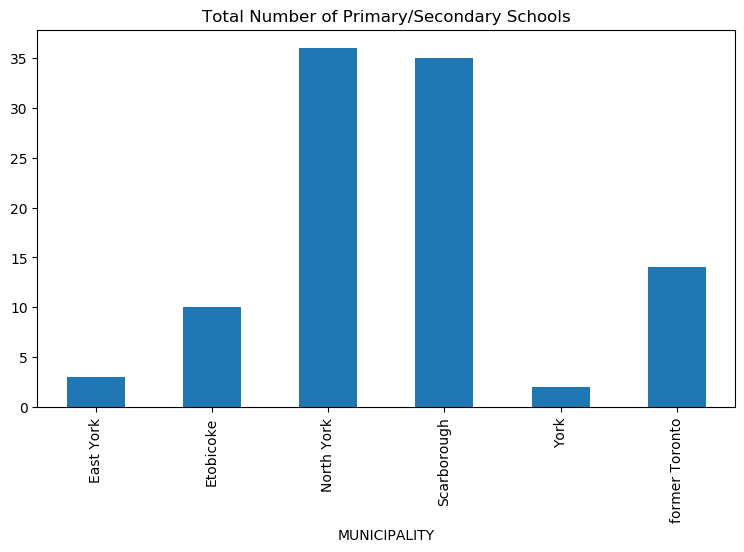

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Total Number of Primary/Secondary Schools')
df_school.groupby('MUNICIPALITY')['OBJECTID'].count().plot(kind='bar')
plt.show()

#### School Type in North York and Scarborough

In [35]:
df_school_ny_scar = df_school.loc[df_school['MUNICIPALITY'].isin(['North York','Scarborough'])]
df_school_ny_scar_counts = df_school_ny_scar[['MUNICIPALITY','SCHOOL_TYPE_DESC','OBJECTID']].groupby(['MUNICIPALITY','SCHOOL_TYPE_DESC'])['OBJECTID'].sum()

In [36]:
df_school_ny_scar_counts = df_school_ny_scar[['MUNICIPALITY','SCHOOL_TYPE_DESC','OBJECTID']].groupby(['MUNICIPALITY','SCHOOL_TYPE_DESC'],as_index=False)['OBJECTID'].sum()

In [37]:
df_school_ny_scar_counts = df_school_ny_scar_counts.rename(columns={'SCHOOL_TYPE_DESC':'School Type',
                                                                    'OBJECTID':'Total Number of School'})

In [38]:
df_school_ny_scar_counts

,MUNICIPALITY,School Type,Total Number of School
0,North York,English Public,625
1,North York,English Separate,55
2,North York,Private,1242
3,Scarborough,English Public,823
4,Scarborough,French Public,8
5,Scarborough,Private,702


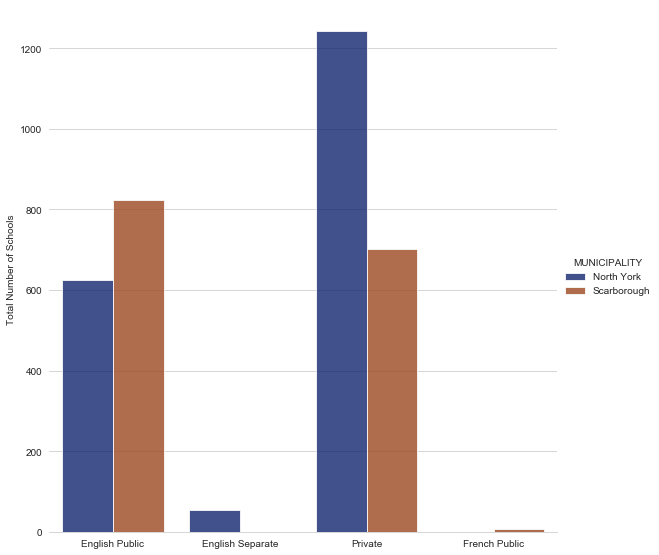

In [39]:
import seaborn as sns
sns.set_style("whitegrid")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_school_ny_scar_counts, kind="bar",
    x="School Type", y="Total Number of School", hue="MUNICIPALITY", 
    palette="dark", alpha=.8, height=8
)
g.despine(left=True)
g.set_axis_labels("", "Total Number of Schools")

### Explore Venues in Scarborough and North York Regions

In [40]:
CLIENT_ID = 'FHF2ETS0NEBHKGW23YN00YGIRPNKBN1BCVWN3VWUWWZWO5SJ' # your Foursquare ID
CLIENT_SECRET = 'ADGYKTZ3CWCPIVTHCPCAYY1CVRWFA5KZH3NQRZR4APUOPZKM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FHF2ETS0NEBHKGW23YN00YGIRPNKBN1BCVWN3VWUWWZWO5SJ
CLIENT_SECRET:ADGYKTZ3CWCPIVTHCPCAYY1CVRWFA5KZH3NQRZR4APUOPZKM


In [41]:
df_tor_only = df_tor.loc[df_tor['Borough'].isin(['North York','Scarborough'])]

#### Return all Venues in North York and Scarborough (1000 radius)

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
Toronto_venues = getNearbyVenues(names=df_tor_only['Neighborhood'],
                                 latitudes=df_tor_only['Latitude'],
                                 longitudes=df_tor_only['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Bedford Park, Lawrence Manor East
Lawrence Manor, Lawrence Heights
Glencairn
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Humberlea, Emery


In [44]:
# Check how many venues by neighbourhood
Toronto_venues.groupby('Neighborhood').count().sort_values('Venue',ascending=False)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Downsview,63,63,63,63,63,63
Don Mills,60,60,60,60,60,60
Agincourt,30,30,30,30,30,30
"Willowdale, Willowdale East",30,30,30,30,30,30
"Willowdale, Newtonbrook",30,30,30,30,30,30
"Wexford, Maryvale",30,30,30,30,30,30
"Lawrence Manor, Lawrence Heights",30,30,30,30,30,30
"Bathurst Manor, Wilson Heights, Downsview North",30,30,30,30,30,30
Glencairn,30,30,30,30,30,30


In [45]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 172 uniques categories.


In [46]:
Toronto_venues['Venue Category'].unique()

array(['Spa', 'Restaurant', 'Fast Food Restaurant', 'Bank',
       'Paper / Office Supplies Store', 'Caribbean Restaurant',
       'Coffee Shop', 'Hobby Shop', 'Trail', 'African Restaurant',
       'Chinese Restaurant', 'Gym', 'Supermarket', 'Bakery', 'Park',
       'Garden', 'Burger Joint', 'Italian Restaurant', 'Breakfast Spot',
       'Playground', 'Fried Chicken Joint', 'Pizza Place',
       'Food & Drink Shop', 'Liquor Store', 'Smoothie Shop', 'Beer Store',
       'Sports Bar', 'Discount Store', 'Pharmacy', 'Sandwich Place',
       'Greek Restaurant', 'Bus Line', 'Moving Target', 'Grocery Store',
       'Dog Run', 'Indian Restaurant', 'Mobile Phone Shop',
       'Hakka Restaurant', 'Thai Restaurant', 'Music Store',
       'Athletics & Sports', 'Gas Station', 'Yoga Studio', 'Wings Joint',
       'Asian Restaurant', 'Intersection', 'Ice Cream Shop',
       'Convenience Store', 'Pool', 'Train Station',
       'Japanese Restaurant', 'Bowling Alley', 'Department Store',
       'Hockey 

In [47]:
Toronto_venues_Chinese = Toronto_venues[(Toronto_venues['Venue Category'] =='Chinese Restaurant')][['Venue','Neighborhood']].reset_index().drop('index',axis=1)

In [48]:
Toronto_venues_with_regions = Toronto_venues_Chinese.merge(df_tor_only,how='left',on=['Neighborhood'])

In [49]:
Toronto_venues_with_regions

,Venue,Neighborhood,Borough,Postcode,Latitude,Longitude
0,Charley's Exotic Cuisine,"Malvern, Rouge",Scarborough,M1B,43.806686,-79.194353
1,Lucky Hakka,Woburn,Scarborough,M1G,43.770992,-79.216917
2,Hakka Legend,Cedarbrae,Scarborough,M1H,43.773136,-79.239476
3,Chung Moi,"Kennedy Park, Ionview, East Birchmount Park",Scarborough,M1K,43.727929,-79.262029
4,Good Luck Chinese Restaurant,"Kennedy Park, Ionview, East Birchmount Park",Scarborough,M1K,43.727929,-79.262029
5,Royal Congee Chinese Cuisine,"Kennedy Park, Ionview, East Birchmount Park",Scarborough,M1K,43.727929,-79.262029
6,Cho's Wok,"Kennedy Park, Ionview, East Birchmount Park",Scarborough,M1K,43.727929,-79.262029
7,Super Choy Restaurant,"Cliffside, Cliffcrest, Scarborough Village West",Scarborough,M1M,43.716316,-79.239476
8,Kim Kim restaurant,"Dorset Park, Wexford Heights, Scarborough Town...",Scarborough,M1P,43.757410,-79.273304
9,Lucky Chinese (Haka) Restaurant,"Dorset Park, Wexford Heights, Scarborough Town...",Scarborough,M1P,43.757410,-79.273304


In [50]:
df_restaurant_counts = Toronto_venues_with_regions[['Venue','Neighborhood','Borough']].groupby(['Borough','Neighborhood'],as_index=False)['Venue'].count()
df_restaurant_counts = df_restaurant_counts.rename(columns={'Venue':'Number of Chinese Restaurant'})
df_restaurant_counts

,Borough,Neighborhood,Number of Chinese Restaurant
0,North York,"Bathurst Manor, Wilson Heights, Downsview North",1
1,North York,Bayview Village,1
2,North York,Don Mills,2
3,North York,Hillcrest Village,1
4,North York,"North Park, Maple Leaf Park, Upwood Park",1
5,North York,"Northwood Park, York University",1
6,North York,Parkwoods,1
7,North York,York Mills West,1
8,Scarborough,Agincourt,4
9,Scarborough,Cedarbrae,1


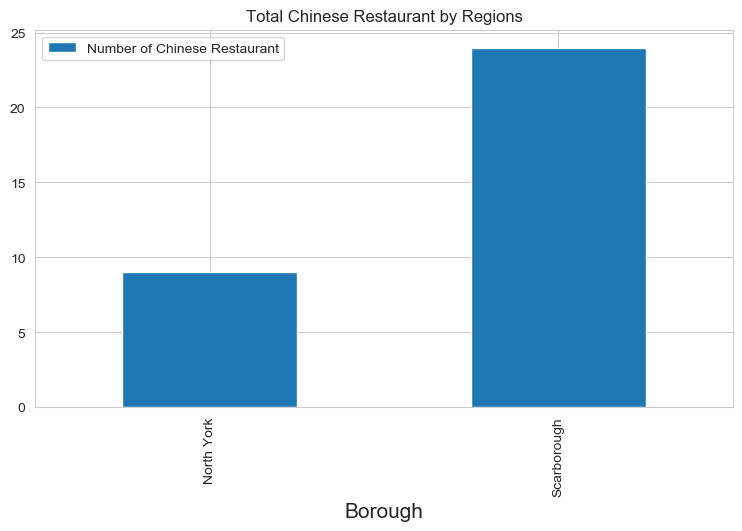

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Total Chinese Restaurant by Regions')
plt.xlabel('Region', fontsize = 15)
df_restaurant_counts.groupby('Borough')['Number of Chinese Restaurant'].sum().plot(kind='bar')
plt.legend()
plt.show()

#### Revisit School Information - Align with Restaurant

In [52]:
df_school_post = df_school[['Postcode','OBJECTID']].groupby(['Postcode'],as_index=False)['OBJECTID'].count()
df_school_post = df_school_post.rename(columns={'OBJECTID':'Total Number of School'})

In [53]:
res_df = Toronto_venues_with_regions[['Postcode','Neighborhood','Borough','Venue']].groupby(['Postcode'],as_index=False)['Venue'].count()
res_df = res_df.rename(columns={'Venue':'Total Number of Chinese Restaurants'})

In [54]:
Chinese_df = res_df.merge(df_school_post ,how='left',on=['Postcode'])
Chinese_df = Chinese_df.fillna(0)
Chinese_df = Chinese_df.merge(df_tor,how='left',on=['Postcode'])
Chinese_df

,Postcode,Total Number of Chinese Restaurants,Total Number of School,Borough,Neighborhood,Latitude,Longitude
0,M1B,1,5.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1G,1,2.0,Scarborough,Woburn,43.770992,-79.216917
2,M1H,1,5.0,Scarborough,Cedarbrae,43.773136,-79.239476
3,M1K,4,1.0,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
4,M1M,1,1.0,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
5,M1P,2,4.0,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304
6,M1S,4,5.0,Scarborough,Agincourt,43.794200,-79.262029
7,M1T,1,0.0,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302
8,M1V,5,6.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577
9,M1W,4,3.0,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389


In [55]:
Chinese_test = Chinese_df[['Total Number of Chinese Restaurants','Total Number of School','Neighborhood']]

### Analyzing Each Neighbourhood

In [56]:
# one hot encoding
toronto_onehot = Chinese_test.drop('Neighborhood',1)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = Chinese_test['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Total Number of Chinese Restaurants,Total Number of School
0,"Malvern, Rouge",1,5.0
1,Woburn,1,2.0
2,Cedarbrae,1,5.0
3,"Kennedy Park, Ionview, East Birchmount Park",4,1.0
4,"Cliffside, Cliffcrest, Scarborough Village West",1,1.0


In [57]:
toronto_onehot.shape

(19, 3)

In [58]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Total Number of Chinese Restaurants,Total Number of School
0,Agincourt,4,5.0
1,"Bathurst Manor, Wilson Heights, Downsview North",1,1.0
2,Bayview Village,1,1.0
3,Cedarbrae,1,5.0
4,"Clarks Corners, Tam O'Shanter, Sullivan",1,0.0


####  Print each neighborhood along with the top 5 most common venues

In [59]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['feature','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                               feature  freq
0               Total Number of School   5.0
1  Total Number of Chinese Restaurants   4.0


----Bathurst Manor, Wilson Heights, Downsview North----
                               feature  freq
0  Total Number of Chinese Restaurants   1.0
1               Total Number of School   1.0


----Bayview Village----
                               feature  freq
0  Total Number of Chinese Restaurants   1.0
1               Total Number of School   1.0


----Cedarbrae----
                               feature  freq
0               Total Number of School   5.0
1  Total Number of Chinese Restaurants   1.0


----Clarks Corners, Tam O'Shanter, Sullivan----
                               feature  freq
0  Total Number of Chinese Restaurants   1.0
1               Total Number of School   0.0


----Cliffside, Cliffcrest, Scarborough Village West----
                               feature  freq
0  Total Number of Chinese Restaurants   1.0
1    

### Clustering

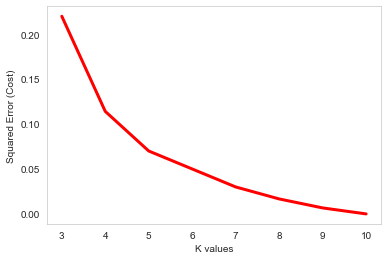

In [60]:
from sklearn.cluster import KMeans

toronto_part_clustering = Chinese_test.drop('Neighborhood', 1)
error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [61]:
!conda install --yes -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

# All requested packages already installed.



/Users/emily/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/emily/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/emily/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/emily/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return_n_iter=True)


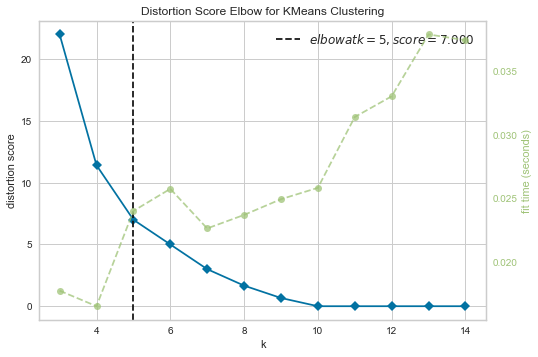

In [67]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15))
visualizer.fit(toronto_part_clustering)
visualizer.show()

In [68]:
kclusters = 5
toronto_part_clustering = Chinese_test.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)
kmeans.labels_

array([3, 2, 3, 1, 0, 3, 4, 0, 4, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0],
      dtype=int32)

#### Merge Back the Clustrer Results into Original Dataframe

In [69]:
Chinese_test.insert(0, 'Cluster Groups', kmeans.labels_)

In [70]:
Chinese_merged = Chinese_df.merge(Chinese_test,how='left', on=['Neighborhood'])

In [71]:
Chinese_merged['Cluster Groups'].astype(int)
Chinese_merged

,Postcode,Total Number of Chinese Restaurants_x,Total Number of School_x,Borough,Neighborhood,Latitude,Longitude,Cluster Groups,Total Number of Chinese Restaurants_y,Total Number of School_y
0,M1B,1,5.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3,1,5.0
1,M1G,1,2.0,Scarborough,Woburn,43.770992,-79.216917,2,1,2.0
2,M1H,1,5.0,Scarborough,Cedarbrae,43.773136,-79.239476,3,1,5.0
3,M1K,4,1.0,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,1,4,1.0
4,M1M,1,1.0,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0,1,1.0
5,M1P,2,4.0,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,3,2,4.0
6,M1S,4,5.0,Scarborough,Agincourt,43.794200,-79.262029,4,4,5.0
7,M1T,1,0.0,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,0,1,0.0
8,M1V,5,6.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,4,5,6.0
9,M1W,4,3.0,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,1,4,3.0


In [72]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chinese_merged['Latitude'], Chinese_merged['Longitude'], Chinese_merged['Neighborhood'], Chinese_merged['Cluster Groups'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### Cluster 0 - One Restaurant & 0-3 School

In [73]:
#Cluster 0
Chinese_merged.loc[Chinese_merged['Cluster Groups'] == 0]

,Postcode,Total Number of Chinese Restaurants_x,Total Number of School_x,Borough,Neighborhood,Latitude,Longitude,Cluster Groups,Total Number of Chinese Restaurants_y,Total Number of School_y
4,M1M,1,1.0,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0,1,1.0
7,M1T,1,0.0,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,0,1,0.0
11,M2K,1,1.0,North York,Bayview Village,43.786947,-79.385975,0,1,1.0
12,M2P,1,0.0,North York,York Mills West,43.752758,-79.400049,0,1,0.0
13,M3A,1,1.0,North York,Parkwoods,43.753259,-79.329656,0,1,1.0
15,M3B,1,3.0,North York,Don Mills,43.745906,-79.352188,0,1,0.0
17,M3C,1,0.0,North York,Don Mills,43.725900,-79.340923,0,1,0.0
18,M3H,1,1.0,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,1,1.0
19,M3J,1,1.0,North York,"Northwood Park, York University",43.767980,-79.487262,0,1,1.0
20,M6L,1,1.0,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,0,1,1.0


#### Cluster 1 - More Restaurants & Few Schools

In [74]:
#Cluster 1
Chinese_merged.loc[Chinese_merged['Cluster Groups'] == 1]

,Postcode,Total Number of Chinese Restaurants_x,Total Number of School_x,Borough,Neighborhood,Latitude,Longitude,Cluster Groups,Total Number of Chinese Restaurants_y,Total Number of School_y
3,M1K,4,1.0,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,1,4,1.0
9,M1W,4,3.0,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,1,4,3.0


#### Cluster 2 - One Restaurants and Few Schools

In [75]:
#Cluster 2
Chinese_merged.loc[Chinese_merged['Cluster Groups'] == 2]

,Postcode,Total Number of Chinese Restaurants_x,Total Number of School_x,Borough,Neighborhood,Latitude,Longitude,Cluster Groups,Total Number of Chinese Restaurants_y,Total Number of School_y
1,M1G,1,2.0,Scarborough,Woburn,43.770992,-79.216917,2,1,2.0
10,M2H,1,2.0,North York,Hillcrest Village,43.803762,-79.363452,2,1,2.0
14,M3B,1,3.0,North York,Don Mills,43.745906,-79.352188,2,1,3.0
16,M3C,1,0.0,North York,Don Mills,43.725900,-79.340923,2,1,3.0


#### Cluster 3 - Less Restaurants & More Schools

In [76]:
#Cluster 3
Chinese_merged.loc[Chinese_merged['Cluster Groups'] == 3]

,Postcode,Total Number of Chinese Restaurants_x,Total Number of School_x,Borough,Neighborhood,Latitude,Longitude,Cluster Groups,Total Number of Chinese Restaurants_y,Total Number of School_y
0,M1B,1,5.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3,1,5.0
2,M1H,1,5.0,Scarborough,Cedarbrae,43.773136,-79.239476,3,1,5.0
5,M1P,2,4.0,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,3,2,4.0


#### Cluster 4 - More shcools & Restaurants

In [77]:
#Cluster 4
Chinese_merged.loc[Chinese_merged['Cluster Groups'] == 4]

,Postcode,Total Number of Chinese Restaurants_x,Total Number of School_x,Borough,Neighborhood,Latitude,Longitude,Cluster Groups,Total Number of Chinese Restaurants_y,Total Number of School_y
6,M1S,4,5.0,Scarborough,Agincourt,43.794200,-79.262029,4,4,5.0
8,M1V,5,6.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,4,5,6.0
